# Clustering
The goal of this phase is to segment products based on their sales behavior over time, identifying groups with similar demand patterns. This supports later forecasting, inventory planning, and category decisions.


In [130]:
# Import necessary libraries
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import numpy as np




In [131]:
# Get the path to the master parquet file and load the data
current = Path.cwd()
while current != current.parent:
    candidate = current / "data_cleaned" / "master.parquet"
    if candidate.exists():
        master_path = candidate
        break
    current = current.parent

df = pd.read_parquet(master_path)
df.head()

,ID_Venta,Fecha,ID_Cliente,ID_Producto,Cantidad,Método_Pago,Estado,Nombre,Apellido,Email,...,Stock,ID_Categoria,Descripción_x,ID_Metodo,Método,Descripción_y,anio,mes,semana,ingreso
0,919,2024-01-31,10,25,5,1,Completa,Stephenie,Sexty,ssexty9@domainmarket.com,...,1640.0,5.0,"Productos congelados, como papas fritas, empan...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,77.25
1,947,2024-01-31,106,5,1,4,Completa,Benedikta,Condon,bcondon2x@paypal.com,...,4929.0,1.0,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,5.65
2,1317,2024-01-31,235,25,3,3,Completa,Cloe,Brun,cbrun6i@theglobeandmail.com,...,1640.0,5.0,"Productos congelados, como papas fritas, empan...",3,Tarjeta de Débito,Pago con tarjetas que debitán directamente de ...,2024,1,5,46.35
3,1607,2024-01-31,114,15,5,1,Completa,Fabien,Roskam,froskam35@desdev.cn,...,4043.0,3.0,"Productos horneados frescos, como pan, factura...",1,Efectivo,"Pago en dinero en efectivo, sin intermediarios...",2024,1,5,17.55
4,2038,2024-01-31,132,2,5,4,Completa,Cassie,Corish,ccorish3n@virginia.edu,...,3358.0,1.0,"Productos lácteos frescos y procesados, como l...",4,Mercado Pago,Plataforma de pagos online que permite realiza...,2024,1,5,26.05


## Aggregate Monthly Demand per Product
We extract the year and month from each transaction timestamp and aggregate the dataset to compute monthly revenue and units sold per product. This creates a time-series view of demand for each product, which is essential for detecting seasonality and demand patterns in the clustering stage.

In [132]:
# Extract year and month from date
df["anio"] = df["Fecha"].dt.year
df["mes"] = df["Fecha"].dt.month

# Aggregate demand per product per month
prod_mes = (
    df.groupby(["ID_Producto", "anio", "mes"], as_index=False)
      .agg(
          ingreso_mensual=("ingreso", "sum"),
          unidades_mensuales=("Cantidad", "sum")
      )
)

prod_mes.head()

,ID_Producto,anio,mes,ingreso_mensual,unidades_mensuales
0,1,2024,2,318.24,26
1,1,2024,3,367.20,30
2,1,2024,4,428.40,35
3,1,2024,5,171.36,14
4,1,2024,6,354.96,29


## Pivot to Product × Month Matrix
We transform the monthly aggregated data into a product × month matrix where each row represents a product and each column represents its revenue in a given month. Missing sales were filled with zeros to maintain a complete 12-month time series. 


In [133]:
# Create pivot table for product monthly income
mat_prod = prod_mes.pivot_table(
    index="ID_Producto",
    columns="mes",
    values="ingreso_mensual",
    aggfunc="sum",
    fill_value=0
)

# Sort columns in calendar order
mat_prod = mat_prod.reindex(sorted(mat_prod.columns), axis=1)

mat_prod.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12
ID_Producto,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05


## Create Derived Features (yearly revenue, monthly volability, stability indicator, margin and payment methods)

Each row represents a product, and the columns capture the key variables used for clustering:
- **Months (1–12):** Monthly revenue for detecting seasonality and peak sales periods.
- **`total_year`:** Total annual revenue.
- **`std_month`:** Volatility of monthly demand.
- **`coef_var`:** Relative variability (stability indicator).
- **Payment mix:** Share of payments made with  
  **Efectivo**, **Tarjeta de Crédito**, **Tarjeta de Débito**, **Mercado Pago**, **Transferencia**.
- **`margen`:** Estimated yearly margin.

In [134]:
mat_prod.index.name = "ID_Producto"
features = mat_prod.copy()

# Total yearly revenue for each product
features["total_year"] = features.sum(axis=1)

# Monthly volatility, this is, standard deviation of monthly revenues per product
features["std_month"] = features.iloc[:, 0:12].std(axis=1)

# Coefficient of variation (stability indicator), defined as std_month / mean_month
features["coef_var"] = features["std_month"] / (features["total_year"] / 12 + 1e-6)

features.head()

mes,1,2,3,4,5,6,7,8,9,10,11,12,total_year,std_month,coef_var
ID_Producto,,,,,,,,,,,,,,,
1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,220.32,440.64,379.44,3378.24,135.094440,0.479875
2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,140.67,57.31,171.93,1422.33,47.445859,0.400294
3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,379.06,172.30,465.21,4617.64,160.346476,0.416697
4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,192.30,249.99,403.83,4980.57,200.760117,0.483704
5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,101.70,192.10,96.05,1695.00,65.580724,0.464288


In [135]:
# ------------------ Payment method distribution per product ----------------------------------------
# Count payment usage per product
payment_counts = (
    df.groupby(["ID_Producto", "Método_Pago"])
      .size()
      .reset_index(name="count")
)

# Convert counts → percentage per product
payment_counts["pct_pago"] = (
    payment_counts["count"] /
    payment_counts.groupby("ID_Producto")["count"].transform("sum")
)

# Pivot to wide format
payment_pivot = payment_counts.pivot(
    index="ID_Producto",
    columns="Método_Pago",
    values="pct_pago"
).fillna(0)

payment_pivot = payment_pivot.reset_index()

# Rename columns (Método codes → names)
method_labels = df[["Método_Pago", "Método"]].drop_duplicates()
rename_map = dict(zip(method_labels["Método_Pago"], method_labels["Método"]))
payment_pivot = payment_pivot.rename(columns=rename_map)

# Mergere, and avoid duplicates if cell is re-run
existing_payment_cols = [col for col in features.columns if col in rename_map.values()]
if existing_payment_cols:
    features = features.drop(columns=existing_payment_cols)

features = features.merge(payment_pivot, on="ID_Producto", how="left")


# ------------------ Add margin per product  ----------------------------------------
# Assume a fixed margin rate of 35%
df["margen"] = df["ingreso"] * 0.35
margin_prod = df.groupby("ID_Producto")["margen"].sum().reset_index()

# If running again, remove old column
if "margen" in features.columns:
    features = features.drop(columns="margen")

features = features.merge(margin_prod, on="ID_Producto", how="left")
print(features.columns)
features.head()

Index([       'ID_Producto',                    1,                    2,
                          3,                    4,                    5,
                          6,                    7,                    8,
                          9,                   10,                   11,
                         12,         'total_year',          'std_month',
                 'coef_var',           'Efectivo', 'Tarjeta de Crédito',
        'Tarjeta de Débito',       'Mercado Pago',      'Transferencia',
                   'margen'],
      dtype='object')


,ID_Producto,1,2,3,4,5,6,7,8,9,...,12,total_year,std_month,coef_var,Efectivo,Tarjeta de Crédito,Tarjeta de Débito,Mercado Pago,Transferencia,margen
0,1,0.00,318.24,367.20,428.40,171.36,354.96,367.20,146.88,183.60,...,379.44,3378.24,135.094440,0.479875,0.197531,0.074074,0.197531,0.185185,0.345679,1182.3840
1,2,26.05,93.78,140.67,104.20,130.25,135.46,104.20,114.62,203.19,...,171.93,1422.33,47.445859,0.400294,0.207317,0.073171,0.268293,0.256098,0.195122,497.8155
2,3,51.69,516.90,620.28,465.21,447.98,465.21,241.22,327.37,465.21,...,465.21,4617.64,160.346476,0.416697,0.214286,0.059524,0.095238,0.333333,0.297619,1616.1740
3,4,0.00,596.13,480.75,615.36,403.83,730.74,384.60,384.60,538.44,...,403.83,4980.57,200.760117,0.483704,0.194805,0.077922,0.168831,0.311688,0.246753,1743.1995
4,5,5.65,101.70,107.35,169.50,265.55,146.90,141.25,192.10,175.15,...,96.05,1695.00,65.580724,0.464288,0.162500,0.062500,0.175000,0.325000,0.275000,593.2500


## Standardize Data
To ensure that all variables contribute fairly to the clustering process, the features were standardized using StandardScaler. Since K-means and similar algorithms rely on distance calculations, variables with larger numerical ranges, such as annual revenue, would dominate the clustering and overshadow smaller-scale variables like volatility or the coefficient of variation. By transforming all features to have mean 0 and standard deviation 1, the model evaluates patterns based on behavior rather than scale.

In [136]:
# Remove ID from scaling
id_col = features["ID_Producto"]
X = features.drop(columns=["ID_Producto"]).values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Determine Optimal Number of Clusters (Hierarchical Clustering Analysis)
This code does hierarchical clustering using four different linkage methods:
- Single linkage: links clusters using the minimum distance between points from each cluster.
- Complete linkage: links clusters using the maximum distance between points.
- Average linkage: uses the average distance between all points in the two clusters.
- Ward linkage: merges clusters in a way that minimizes the increase in total variance.

Dendrogram plots were then prouced for each one. 

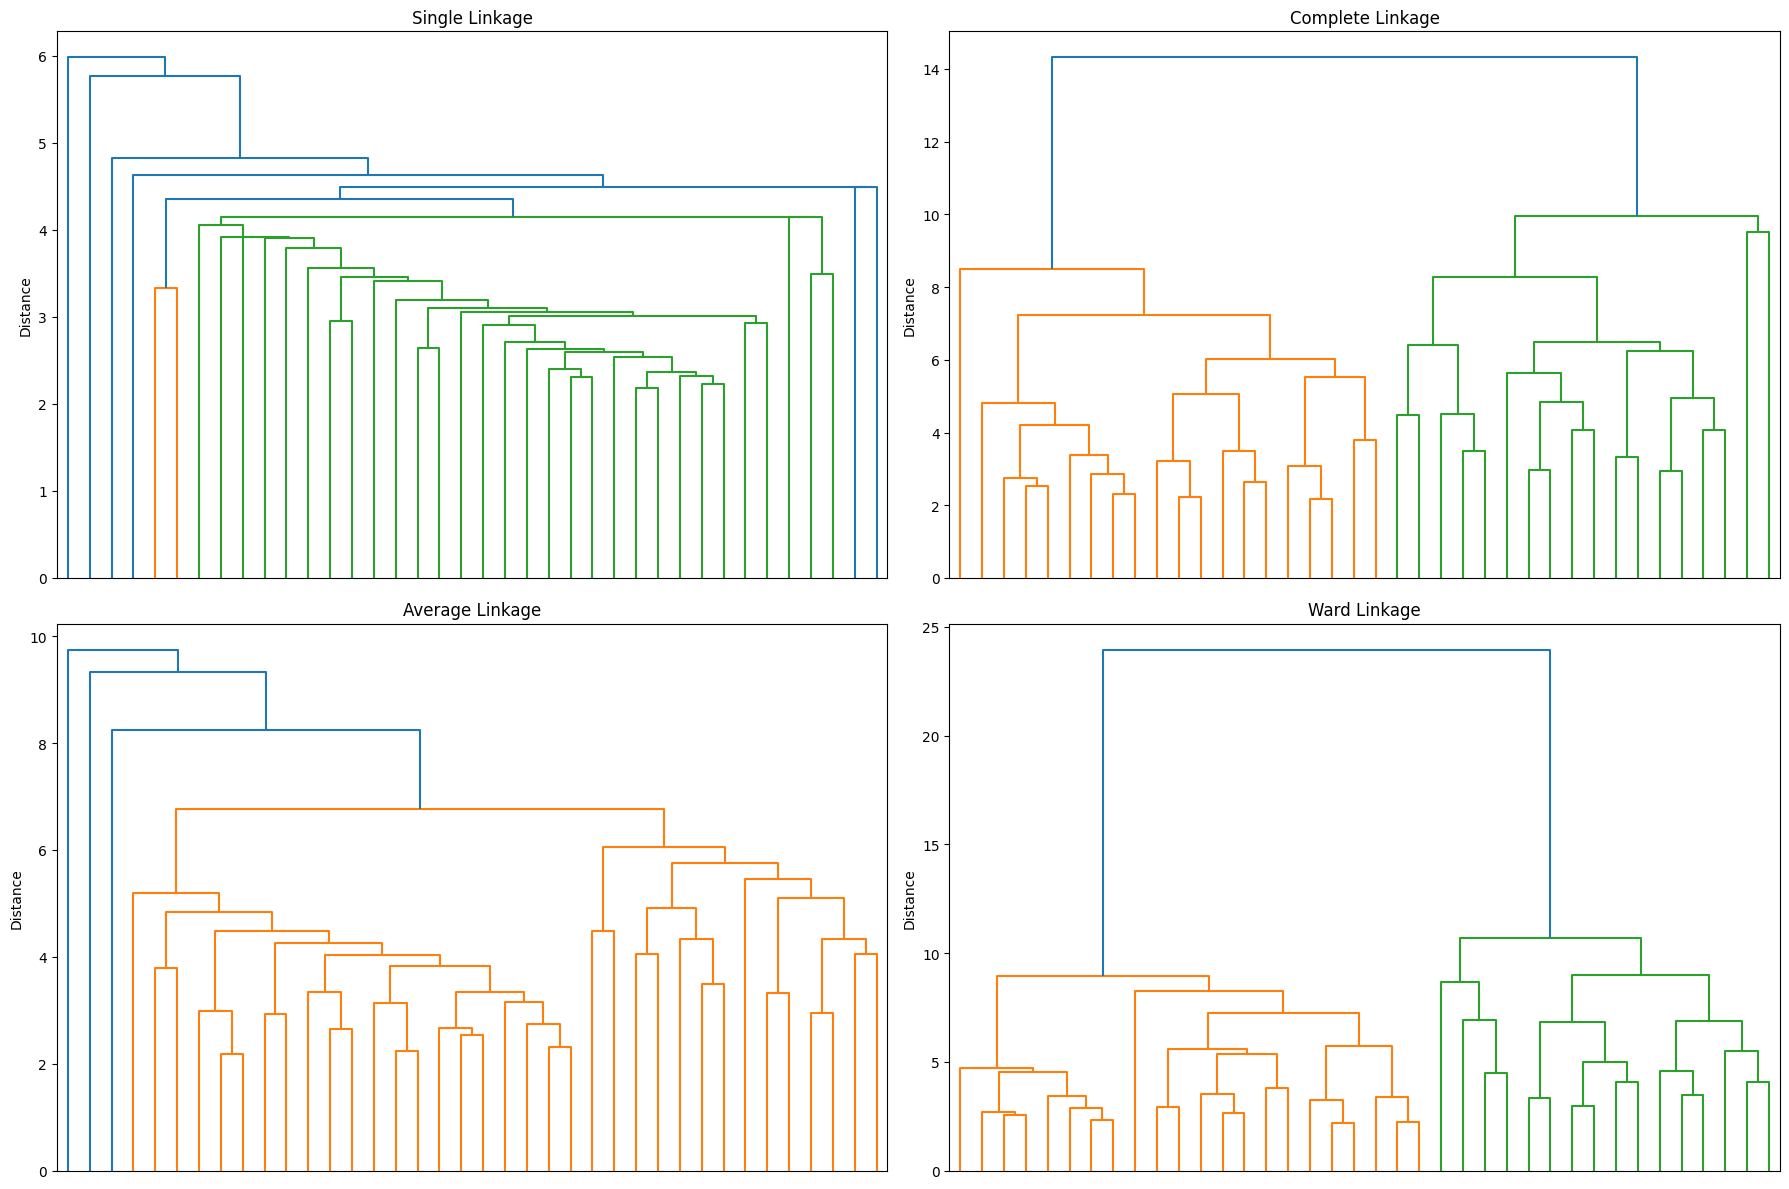

In [137]:
Z_single = linkage(X_scaled, method='single')
Z_complete = linkage(X_scaled, method='complete')
Z_average = linkage(X_scaled, method='average')
Z_ward = linkage(X_scaled, method='ward')

# Plot all the dendograms
plt.figure(figsize=(18, 12))

# Single linkage
plt.subplot(2, 2, 1)
dendrogram(Z_single, no_labels=True)
plt.title("Single Linkage")
plt.ylabel("Distance")

# Complete linkage
plt.subplot(2, 2, 2)
dendrogram(Z_complete, no_labels=True)
plt.title("Complete Linkage")
plt.ylabel("Distance")

# Average linkage
plt.subplot(2, 2, 3)
dendrogram(Z_average, no_labels=True)
plt.title("Average Linkage")
plt.ylabel("Distance")

# Ward linkage
plt.subplot(2, 2, 4)
dendrogram(Z_ward, no_labels=True)
plt.title("Ward Linkage")
plt.ylabel("Distance")

plt.tight_layout()
plt.show()

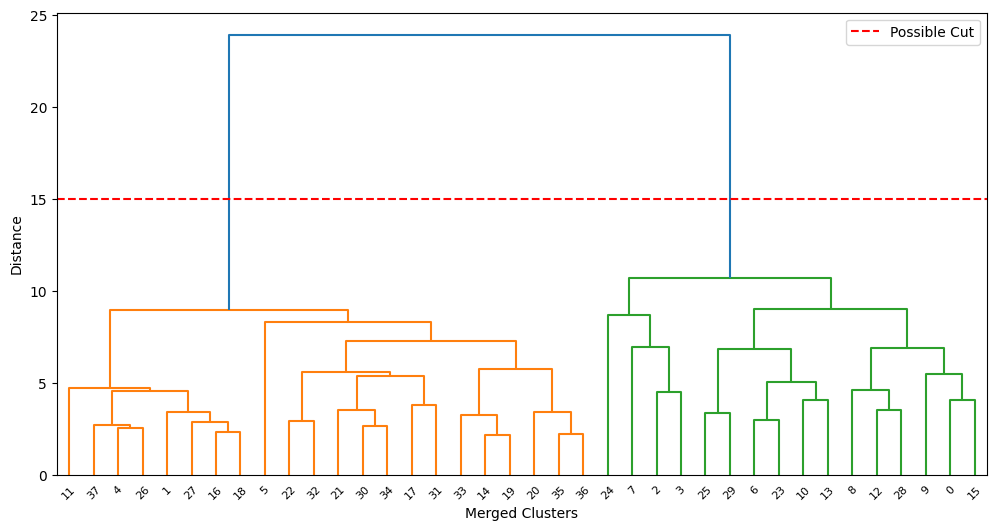

In [138]:
# Ward diagram with cut line
plt.figure(figsize=(12, 6))
dendrogram(Z_ward, truncate_mode="lastp", p=40)
plt.axhline(y=15, color='red', linestyle='--', label='Possible Cut')
plt.xlabel("Merged Clusters")
plt.ylabel("Distance")
plt.legend()
plt.show()

### Calculating silhouette scores

In [139]:
# Calculate the silhouette scores for k = 2,3,4
cluster_results = {}
for k in [2, 3, 4,]:
    labels = fcluster(Z_ward, k, criterion="maxclust")
    cluster_results[k] = labels
    
sscores = {}
for k, labels in cluster_results.items():
    score = silhouette_score(X_scaled, labels)
    sscores[k] = score

# Create a table
summary_df = pd.DataFrame({
    "k": list(sscores.keys()),
    "Silhouette Score": list(sscores.values())
})
summary_df.style.format({"Silhouette Score": "{:.4f}"})


,k,Silhouette Score
0,2,0.2960
1,3,0.2355
2,4,0.2072


## Determine Optimal Number of Clusters (Elbow + Silhouette)
This step calculates how many clusters best fit the data by using the Elbow Method and the Silhouette Score:
- The Elbow Method looks at how much the total within-cluster distance (inertia) decreases as k increases. 
- The Silhouette Score evaluates how well each point fits within its assigned cluster, compared to other clusters. Higher scores mean clearer, better-separated clusters.


In [140]:
# Calculate inertia (k = 1 to 10) and silhouette (k = 2 to 10)
inertias = []
silhouettes = []
k_values_elbow = range(1, 11)   # For inertia
k_values_silhouette = range(2, 11)  # For silhouette

# Compute inertia for k = 1 to 10
for k in k_values_elbow:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    model.fit(X_scaled)
    inertias.append(model.inertia_)

# Compute silhouette for k = 2 to 10
for k in k_values_silhouette:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X_scaled)
    silhouettes.append(silhouette_score(X_scaled, labels))

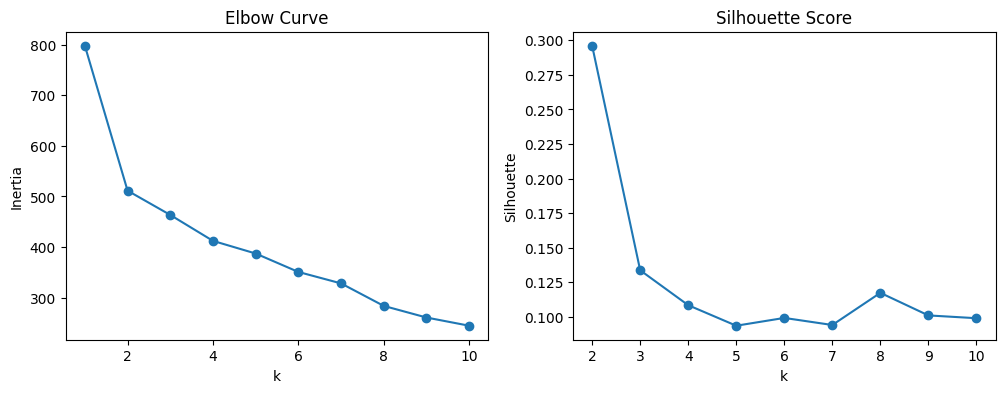

In [141]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(k_values_elbow, inertias, marker="o")
plt.title("Elbow Curve")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_values_silhouette, silhouettes, marker="o")
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Silhouette")

plt.show()

- The Elbow Curve shows a clear inflection at k = 2, indicating diminishing returns in inertia reduction beyond this point.
- The Silhouette Score is also highest at k = 2.

Considering both metrics together, and balancing separation quality with practical interpretability, the selected number of clusters is: k = 2.

## Run Final K-Means 

In [147]:
k_opt = 2
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)
features["cluster"] = labels

# Calculate cluster sizes
cluster_counts = features["cluster"].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(features)) * 100

print("Cluster Counts:")
print(cluster_counts)

print("\nCluster Percentages (%):")
print(cluster_percentages.round(3))

# Key cluster metrics
cluster_profile = (
    features.groupby("cluster")[
        ["total_year", "std_month", "coef_var",
         "Efectivo", "Tarjeta de Crédito", "Tarjeta de Débito",
         "Mercado Pago", "Transferencia", "margen"]
    ]
    .mean()
)

# Monthly pattern
monthly_cols = list(range(1,13))
cluster_month_pattern = (
    features.groupby("cluster")[monthly_cols]
    .mean()
)

cluster_assignments = features[["ID_Producto", "cluster"]]
cluster_assignments



Cluster Counts:
cluster
0    22
1    16
Name: count, dtype: int64

Cluster Percentages (%):
cluster
0    57.895
1    42.105
Name: count, dtype: float64


,ID_Producto,cluster
0,1,1
1,2,0
2,3,1
3,4,1
4,5,0
5,6,0
6,7,1
7,8,1
8,9,1
9,10,1


## Heatmap of Monthly Patterns and cluster metrics

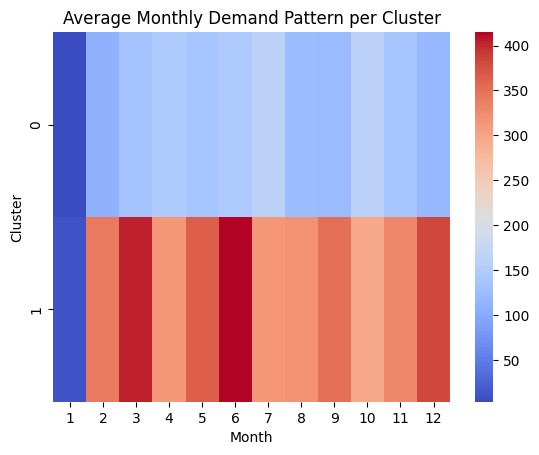

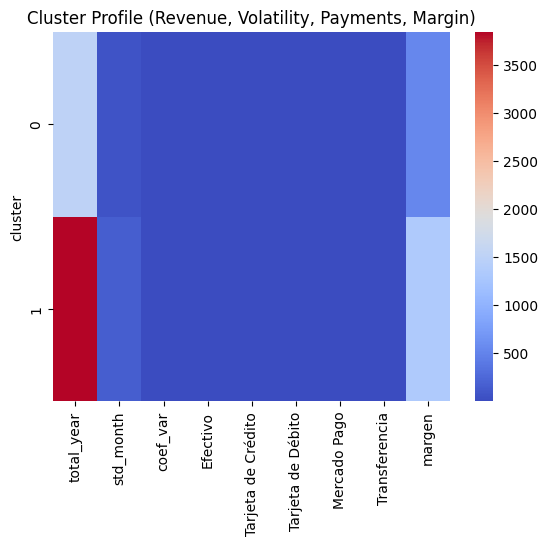

In [143]:
sns.heatmap(cluster_month_pattern, annot=False, cmap="coolwarm")
plt.title("Average Monthly Demand Pattern per Cluster")
plt.xlabel("Month")
plt.ylabel("Cluster")
plt.show()

sns.heatmap(cluster_profile, annot=False, cmap="coolwarm")
plt.title("Cluster Profile (Revenue, Volatility, Payments, Margin)")
plt.show()

## Cluster Profiling and Interpretation


Cluster Mean Profiles:


,1,2,3,4,5,6,7,8,9,10,...,12,total_year,std_month,coef_var,Efectivo,Tarjeta de Crédito,Tarjeta de Débito,Mercado Pago,Transferencia,margen
cluster,,,,,,,,,,,,,,,,,,,,,
0,3.667727,108.741364,135.208182,147.895455,135.960909,146.257273,161.700909,123.637273,122.542727,162.575455,...,118.391818,1503.159545,66.683984,0.515858,0.187970,0.088580,0.184045,0.281603,0.257802,526.105841
1,10.955625,342.565000,404.483750,313.181250,363.832500,414.961250,314.930000,318.996875,351.491875,297.006250,...,381.441875,3843.390000,160.620835,0.509298,0.176047,0.082065,0.170677,0.299736,0.271475,1345.186500


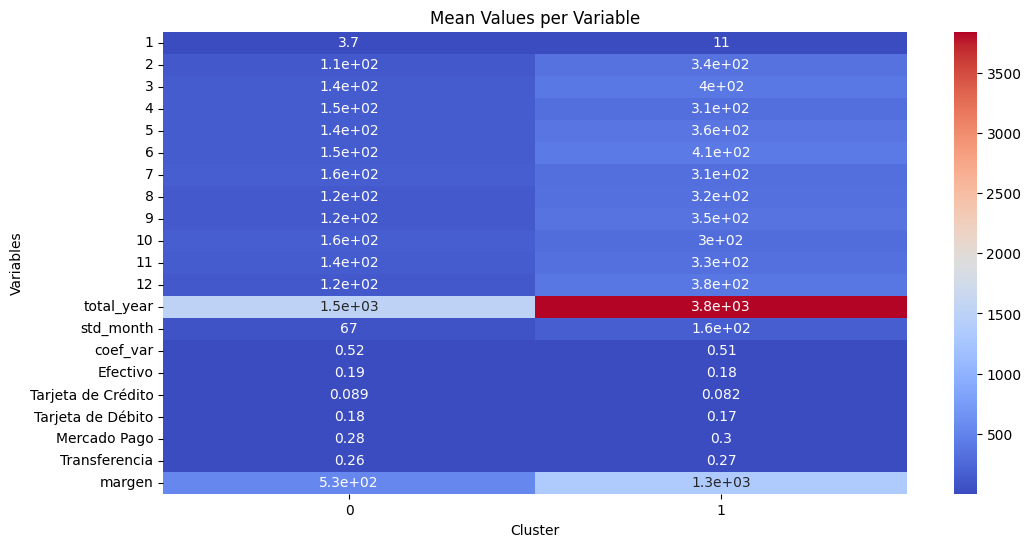

In [144]:
# Calculate cluster means
cluster_profile = (features.drop(columns=["ID_Producto"]).groupby("cluster").mean())

print("Cluster Mean Profiles:")
display(cluster_profile)

# Create heatmap 
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profile.T, cmap="coolwarm", annot=True)
plt.title("Mean Values per Variable")
plt.xlabel("Cluster")
plt.ylabel("Variables")
plt.show()

**Low-Activity Essentials:** Cluster 0 represents products with low monthly revenue, low yearly margin, and low volatility. These items sell in smaller quantities but more steadily over time.
Products:
2  - Yogur
5  - Manteca
6  - Asado
12 - Pan francés
15 - Medialunas
17 - Manzanas
18 - Bananas
19 - Tomates
20 - Lechugas
21 - Zanahorias
22 - Cebolla
23 - Papas fritas
27 - Agua mineral
28 - Jugos de frutas
31 - Galletitas de agua
32 - Galletitas de chocolate
33 - Papas chips
34 - Maníes
35 - Arroz
36 - Lentejas
37 - Garbanzos
38 - Atún enlatado


**High-Activity Performers:** Cluster 1 represents products with high monthly revenue, high yearly margin, and higher volatility. These items generate most of the income but fluctuate more in demand.
Products:
1  - Leche
3  - Queso cremoso
4  - Queso rallado
7  - Chorizo
8  - Milanesa
9  - Pollo
10 - Costilla de cerdo
11 - Salchicha
13 - Pan integral
14 - Facturas
16 - Tortas
24 - Empanadas
25 - Pizza congelada
26 - Hamburguesas congeladas
29 - Cerveza
30 - Vino tinto

The payment methods between the two product groups were very similar, with only small differences in the proportions of each method used.

## Cluster Validation - Silhouette Analysis

Average Silhouette Score: 0.296


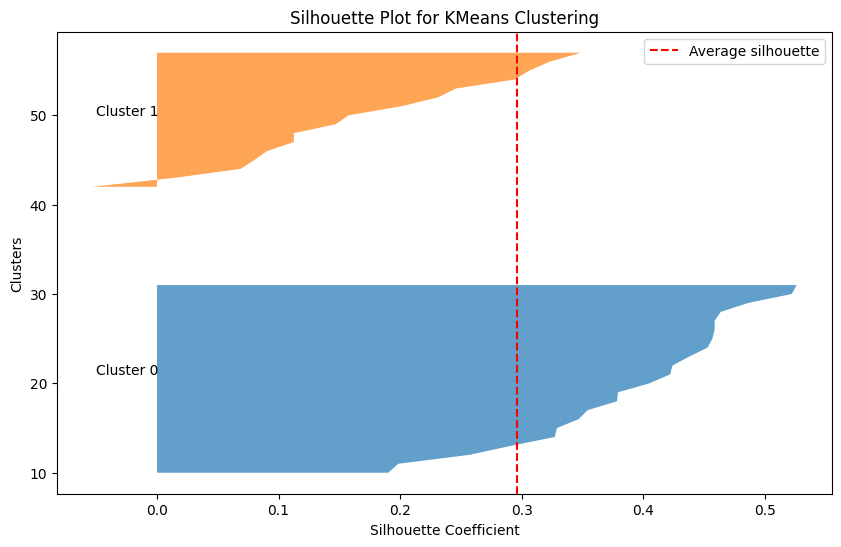

In [145]:
# Compute silhouette scores for each product
sil_values = silhouette_samples(X_scaled, features["cluster"])

# Overall silhouette avg
sil_avg = silhouette_score(X_scaled, features["cluster"])
print("Average Silhouette Score:", round(sil_avg, 3))

# Prepare plot
plt.figure(figsize=(10, 6))

y_lower = 10
for cluster in sorted(features["cluster"].unique()):
    # Extract silhouette values for cluster
    c_sil = sil_values[features["cluster"] == cluster]
    c_sil.sort()
    size_c = c_sil.shape[0]
    y_upper = y_lower + size_c
    
    # Plot the silhouette values for cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, c_sil, alpha=0.7)
    plt.text(-0.05, y_lower + size_c / 2, f"Cluster {cluster}")
    
    y_lower = y_upper + 10

plt.axvline(sil_avg, color="red", linestyle="--", label="Average silhouette")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Clusters")
plt.title("Silhouette Plot for KMeans Clustering")
plt.legend()
plt.show()

## Cluster Visualization (PCA Projection)

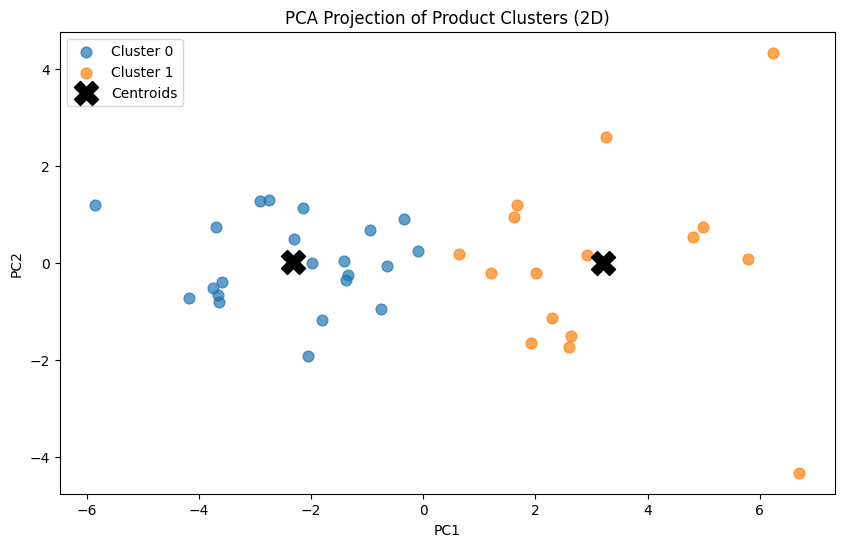

PC1 explains: 47.96%
PC2 explains: 9.18%
Total variance explained: 57.14%


In [146]:
# Apply PCA to the standardized product-level data
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# Add PCA components to the product-level features dataframe
features["PC1"] = pcs[:, 0]
features["PC2"] = pcs[:, 1]

# Plot PCA scatter with clusters
plt.figure(figsize=(10, 6))

for cluster in sorted(features["cluster"].unique()):
    subset = features[features["cluster"] == cluster]
    plt.scatter(subset["PC1"], subset["PC2"], s=60, alpha=0.7, label=f"Cluster {cluster}")

# Plot centroids
centroids = features.groupby("cluster")[["PC1", "PC2"]].mean()
plt.scatter(
    centroids["PC1"],
    centroids["PC2"],
    s=300,
    c="black",
    marker="X",
    label="Centroids"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection of Product Clusters (2D)")
plt.legend()
plt.show()

# Print variance explained
var_exp = pca.explained_variance_ratio_
print(f"PC1 explains: {var_exp[0]*100:.2f}%")
print(f"PC2 explains: {var_exp[1]*100:.2f}%")
print(f"Total variance explained: {var_exp.sum()*100:.2f}%")

## Technical Conclusion
Using monthly revenue, volatility, payment-method shares, and margin features, we standardized the data and applied hierarchical clustering and K-Means to segment products. Both the dendrogram structure and the Elbow/Silhouette analyses consistently indicated k = 2 as the optimal number of clusters. After running K-Means, the two product groups showed clear differences in demand levels. PCA confirmed the separation visually.